# Converting from grid-based to municipality-based

The following steps were done to convert created grid_based dataset to municipality_based one:

import the weight file to a dataframe

assign the values to each grid 

multiply the damaged values with the weights

Aggregate the values by municipality and typhoon_name 

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from utils import get_training_dataset, weight_file

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Import the created dataset to a df
df = get_training_dataset()
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0
...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,0.0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,0.0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,0.0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,0.0


In [4]:
# Check values greater than 100
(df["percent_houses_damaged"] > 100).sum()

for i in range(len(df)):
    a = df.loc[i, "percent_houses_damaged"]
    if a > 100:
        print(a)

251.474732044657
100.25359097066338
100.36104807097172


In [5]:
# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [6]:
# Read the new weight CSV file and import to a df
df_weight = weight_file("/ggl_grid_to_mun_weights.csv")
df_weight.head()

,ADM3_PCODE,id_x,Centroid,numbuildings_x,id,numbuildings,weight
0,PH012801000,11049.0,120.9E_18.5N,1052,11049,1794,0.586399
1,PH012810000,11049.0,120.9E_18.5N,0,11049,1794,0.000000
2,PH012815000,11049.0,120.9E_18.5N,742,11049,1794,0.413601
3,PH012801000,11050.0,120.9E_18.4N,193,11050,196,0.984694
4,PH012810000,11050.0,120.9E_18.4N,0,11050,196,0.000000


In [7]:
# Check if two grid_id columns are equal first need to convert 'id_x' columns from float to int

# df_weight["id_x"] = df_weight["id_x"].astype(np.int64)
# df_weight["id_x"].equals(df_weight["id"])

In [8]:
# Change name of column ['id'] to ['grid_point_id'] the same name as in input df
df_weight.rename(columns={"id": "grid_point_id"}, inplace=True)
df_weight.head()

,ADM3_PCODE,id_x,Centroid,numbuildings_x,grid_point_id,numbuildings,weight
0,PH012801000,11049.0,120.9E_18.5N,1052,11049,1794,0.586399
1,PH012810000,11049.0,120.9E_18.5N,0,11049,1794,0.000000
2,PH012815000,11049.0,120.9E_18.5N,742,11049,1794,0.413601
3,PH012801000,11050.0,120.9E_18.4N,193,11050,196,0.984694
4,PH012810000,11050.0,120.9E_18.4N,0,11050,196,0.000000


### Following Steps are to convert grid_based model into Municipality based one

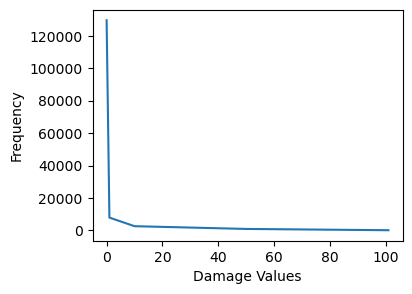

In [9]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [10]:
# Check the bins' intervalls
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    129600
(9e-05, 1.0]         7938
(1.0, 10.0]          2634
(10.0, 50.0]          939
(50.0, 101.0]         147
Name: percent_houses_damaged, dtype: int64

In [11]:
# Remove zeros from wind_speed
# df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df_data = df.drop(columns=["grid_point_id", "typhoon_year"])

In [12]:
display(df.head())
display(df_data.head())

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0


,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged
0,DURIAN,0.0,303.180555,0.122917,0.085417,31.000000,NaN,0.0
1,DURIAN,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0
2,DURIAN,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0
3,DURIAN,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0
4,DURIAN,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0


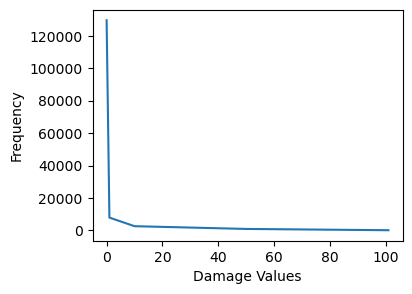

In [13]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df_data["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [14]:
print(samples_per_bin2)
print(binsP2)

[129600   7938   2634    939    147]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [15]:
# Check the bins' intervalls
df_data["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    129600
(9e-05, 1.0]         7938
(1.0, 10.0]          2634
(10.0, 50.0]          939
(50.0, 101.0]         147
Name: percent_houses_damaged, dtype: int64

In [16]:
bin_index2 = np.digitize(df_data["percent_houses_damaged"], bins=binsP2)

In [17]:
y_input_strat = bin_index2

In [18]:
features = [
    "wind_speed",
    # "track_distance",
    # "total_houses",
    # "rainfall_max_6h",
    # "rainfall_max_24h"
    # "rwi"
]

# Split X and y from dataframe features
X = df_data[features]
display(X.columns)
y = df_data["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed'], dtype='object')

In [19]:
# Define train-test-split function

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    df_data["percent_houses_damaged"],
    stratify=y_input_strat,
    test_size=0.2,
)

# Define XGBoost Reduced Overfitting model
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

[14:49:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.123
Model:                                OLS   Adj. R-squared:                  0.123
Method:                     Least Squares   F-statistic:                 1.579e+04
Date:                    Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                            14:49:15   Log-Likelihood:            -2.7894e+05
No. Observations:                  113006   AIC:                 

In [20]:
# Combine test and training set to have predictiob for all
y_pred_all = xgb.predict(X_scaled)
pred_df = pd.DataFrame(columns=["y_all", "y_pred_all"])
pred_df["y_all"] = df_data["percent_houses_damaged"]
pred_df["y_pred_all"] = y_pred_all

pred_df

,y_all,y_pred_all
0,0.0,0.020261
1,0.0,0.020261
2,0.0,0.020261
3,0.0,0.020261
4,0.0,0.020261
...,...,...
141253,0.0,0.020261
141254,0.0,0.020261
141255,0.0,0.020261
141256,0.0,0.020261


In [21]:
# Join data with y_all and y_all_pred
df_data_w_pred = pd.merge(pred_df, df_data, left_index=True, right_index=True)
# Join data with grid_point_id typhoon_year
df_data_w_pred_grid = pd.merge(
    df[["grid_point_id", "typhoon_year"]],
    df_data_w_pred,
    left_index=True,
    right_index=True,
)

In [22]:
df_data_w_pred_grid.sort_values("y_pred_all", ascending=False)

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged
32064,18303,2013,57.235598,79.558975,HAIYAN,72.251930,31.753148,9.260417,5.607813,2383.683635,0.308800,57.235598
32121,18470,2013,94.285260,79.558975,HAIYAN,72.231420,33.730735,8.783333,5.559896,251.827606,-0.666000,94.285260
32379,19307,2013,80.748749,78.423950,HAIYAN,73.230522,21.753512,9.266667,5.344792,1625.734579,-0.096571,80.748749
32122,18471,2013,95.240679,78.423950,HAIYAN,73.246757,22.798157,8.610417,6.385937,2786.766802,0.045714,95.240679
31892,17803,2013,78.666474,70.301445,HAIYAN,72.451338,14.887811,8.708333,4.740104,11310.366765,-0.212280,78.666474
...,...,...,...,...,...,...,...,...,...,...,...,...
58571,10889,2014,0.000000,0.020261,LINGLING,0.000000,1149.656762,0.000000,0.000000,290.917874,-0.411714,0.000000
58570,10888,2014,0.000000,0.020261,LINGLING,0.000000,1158.054191,0.000000,0.000000,9.442258,NaN,0.000000
58569,10887,2014,0.000000,0.020261,LINGLING,0.000000,1166.496984,0.000000,0.000000,1197.958689,-0.354000,0.000000
58568,10886,2014,0.000000,0.020261,LINGLING,0.000000,1174.984163,0.000000,0.000000,5664.484019,-0.089571,0.000000


In [23]:
# join with weights df
join_df = df_data_w_pred_grid.merge(df_weight, on="grid_point_id", how="left")
join_df

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged,ADM3_PCODE,id_x,Centroid,numbuildings_x,numbuildings,weight
0,101,2006,0.0,0.020261,DURIAN,0.0,303.180555,0.122917,0.085417,31.000000,NaN,0.0,PH175321000,101.0,114.3E_11.1N,1,1,1.000000
1,4475,2006,0.0,0.020261,DURIAN,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0,PH175304000,4475.0,116.9E_7.9N,3,3,1.000000
2,4639,2006,0.0,0.020261,DURIAN,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0,PH175304000,4639.0,117.0E_8.2N,11,11,1.000000
3,4640,2006,0.0,0.020261,DURIAN,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0,PH175304000,4640.0,117.0E_8.1N,587,587,1.000000
4,4641,2006,0.0,0.020261,DURIAN,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0,PH175304000,4641.0,117.0E_8.0N,974,974,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381415,20679,2020,0.0,0.020261,MOLAVE,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,0.0,PH112501000,20679.0,126.6E_7.4N,459,1484,0.309299
381416,20679,2020,0.0,0.020261,MOLAVE,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,0.0,PH112504000,20679.0,126.6E_7.4N,1025,1484,0.690701
381417,20680,2020,0.0,0.020261,MOLAVE,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,0.0,PH112504000,20680.0,126.6E_7.3N,2708,2798,0.967834
381418,20680,2020,0.0,0.020261,MOLAVE,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,0.0,PH112508000,20680.0,126.6E_7.3N,90,2798,0.032166


In [24]:
# Indicate where values are valid and not missing
join_df = join_df.loc[join_df["weight"].notna()]
join_df

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged,ADM3_PCODE,id_x,Centroid,numbuildings_x,numbuildings,weight
0,101,2006,0.0,0.020261,DURIAN,0.0,303.180555,0.122917,0.085417,31.000000,NaN,0.0,PH175321000,101.0,114.3E_11.1N,1,1,1.000000
1,4475,2006,0.0,0.020261,DURIAN,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0,PH175304000,4475.0,116.9E_7.9N,3,3,1.000000
2,4639,2006,0.0,0.020261,DURIAN,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0,PH175304000,4639.0,117.0E_8.2N,11,11,1.000000
3,4640,2006,0.0,0.020261,DURIAN,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0,PH175304000,4640.0,117.0E_8.1N,587,587,1.000000
4,4641,2006,0.0,0.020261,DURIAN,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0,PH175304000,4641.0,117.0E_8.0N,974,974,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381415,20679,2020,0.0,0.020261,MOLAVE,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,0.0,PH112501000,20679.0,126.6E_7.4N,459,1484,0.309299
381416,20679,2020,0.0,0.020261,MOLAVE,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,0.0,PH112504000,20679.0,126.6E_7.4N,1025,1484,0.690701
381417,20680,2020,0.0,0.020261,MOLAVE,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,0.0,PH112504000,20680.0,126.6E_7.3N,2708,2798,0.967834
381418,20680,2020,0.0,0.020261,MOLAVE,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,0.0,PH112508000,20680.0,126.6E_7.3N,90,2798,0.032166


In [25]:
# Multiply weight by y_all and y_pred_all
join_df["weight*y_pred*houses"] = (
    join_df["y_pred_all"] * join_df["weight"] * join_df["total_houses"] / 100
)
join_df["weight*y*houses"] = (
    join_df["y_all"] * join_df["weight"] * join_df["total_houses"] / 100
)
join_df["weight*houses"] = join_df["weight"] * join_df["total_houses"]
join_df

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,...,percent_houses_damaged,ADM3_PCODE,id_x,Centroid,numbuildings_x,numbuildings,weight,weight*y_pred*houses,weight*y*houses,weight*houses
0,101,2006,0.0,0.020261,DURIAN,0.0,303.180555,0.122917,0.085417,31.000000,...,0.0,PH175321000,101.0,114.3E_11.1N,1,1,1.000000,0.006281,0.0,31.000000
1,4475,2006,0.0,0.020261,DURIAN,0.0,638.027502,0.091667,0.027083,3.301020,...,0.0,PH175304000,4475.0,116.9E_7.9N,3,3,1.000000,0.000669,0.0,3.301020
2,4639,2006,0.0,0.020261,DURIAN,0.0,603.631997,0.535417,0.146354,12.103741,...,0.0,PH175304000,4639.0,117.0E_8.2N,11,11,1.000000,0.002452,0.0,12.103741
3,4640,2006,0.0,0.020261,DURIAN,0.0,614.675270,0.356250,0.101562,645.899660,...,0.0,PH175304000,4640.0,117.0E_8.1N,587,587,1.000000,0.130868,0.0,645.899660
4,4641,2006,0.0,0.020261,DURIAN,0.0,625.720905,0.202083,0.057812,1071.731293,...,0.0,PH175304000,4641.0,117.0E_8.0N,974,974,1.000000,0.217148,0.0,1071.731293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381415,20679,2020,0.0,0.020261,MOLAVE,0.0,666.794635,2.975000,0.949479,930.647069,...,0.0,PH112501000,20679.0,126.6E_7.4N,459,1484,0.309299,0.058322,0.0,287.848386
381416,20679,2020,0.0,0.020261,MOLAVE,0.0,666.794635,2.975000,0.949479,930.647069,...,0.0,PH112504000,20679.0,126.6E_7.4N,1025,1484,0.690701,0.130240,0.0,642.798683
381417,20680,2020,0.0,0.020261,MOLAVE,0.0,677.904037,2.889583,1.083333,1800.666044,...,0.0,PH112504000,20680.0,126.6E_7.3N,2708,2798,0.967834,0.353105,0.0,1742.746122
381418,20680,2020,0.0,0.020261,MOLAVE,0.0,677.904037,2.889583,1.083333,1800.666044,...,0.0,PH112508000,20680.0,126.6E_7.3N,90,2798,0.032166,0.011735,0.0,57.919923


In [26]:
join_df.sort_values("y_pred_all", ascending=False)

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,...,percent_houses_damaged,ADM3_PCODE,id_x,Centroid,numbuildings_x,numbuildings,weight,weight*y_pred*houses,weight*y*houses,weight*houses
86903,18470,2013,94.285260,79.558975,HAIYAN,72.231420,33.730735,8.783333,5.559896,251.827606,...,94.285260,PH082612000,18470.0,125.3E_11.2N,339,401,0.845387,169.374428,200.725460,212.891667
86902,18470,2013,94.285260,79.558975,HAIYAN,72.231420,33.730735,8.783333,5.559896,251.827606,...,94.285260,PH082602000,18470.0,125.3E_11.2N,62,401,0.154613,30.977034,36.710851,38.935939
86752,18303,2013,57.235598,79.558975,HAIYAN,72.251930,31.753148,9.260417,5.607813,2383.683635,...,57.235598,PH086010000,18303.0,125.2E_11.2N,3848,3853,0.998702,1893.973289,1362.545114,2380.590353
86751,18303,2013,57.235598,79.558975,HAIYAN,72.251930,31.753148,9.260417,5.607813,2383.683635,...,57.235598,PH082612000,18303.0,125.2E_11.2N,5,3853,0.001298,2.460984,1.770459,3.093283
87506,19307,2013,80.748749,78.423950,HAIYAN,73.230522,21.753512,9.266667,5.344792,1625.734579,...,80.748749,PH082609000,19307.0,125.8E_11.0N,2556,2556,1.000000,1274.965276,1312.760341,1625.734579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159774,12228,2014,0.000000,0.020261,LINGLING,0.000000,1067.080548,0.045833,0.011458,3519.226784,...,0.000000,PH021512000,12228.0,121.6E_17.5N,1427,8263,0.172698,0.123141,0.000000,607.761905
159773,12227,2014,0.000000,0.020261,LINGLING,0.000000,1075.778390,0.043750,0.010937,4562.888107,...,0.000000,PH143211000,12227.0,121.6E_17.6N,505,10925,0.046224,0.042735,0.000000,210.916109
159772,12227,2014,0.000000,0.020261,LINGLING,0.000000,1075.778390,0.043750,0.010937,4562.888107,...,0.000000,PH021528000,12227.0,121.6E_17.6N,21,10925,0.001922,0.001777,0.000000,8.770769
159771,12227,2014,0.000000,0.020261,LINGLING,0.000000,1075.778390,0.043750,0.010937,4562.888107,...,0.000000,PH021527000,12227.0,121.6E_17.6N,9532,10925,0.872494,0.806625,0.000000,3981.093770


In [27]:
# Groupby by municipality and typhoon_name with sum as the aggregation function
agg_df = join_df.groupby(["ADM3_PCODE", "typhoon_name", "typhoon_year"]).agg("sum")

# Normalize by the sum of the weights
agg_df["y_pred_norm"] = agg_df["weight*y_pred*houses"] / agg_df["weight*houses"] * 100
agg_df["y_norm"] = agg_df["weight*y*houses"] / agg_df["weight*houses"] * 100

# Drop not required column y and y_pred before multiplying by weight
agg_df.drop("y_all", axis=1, inplace=True)
agg_df.drop("y_pred_all", axis=1, inplace=True)

agg_df

grid_point_id  wind_speed  \
ADM3_PCODE  typhoon_name typhoon_year                              
PH012801000 BOPHA        2012                  44532   74.049638   
            CONSON       2010                  44532    0.000000   
            DURIAN       2006                  44532    0.000000   
            FENGSHEN     2008                  44532   44.394129   
            FUNG-WONG    2014                  44532   61.869817   
...                                              ...         ...   
PH175917000 USAGI        2013                  39174    0.000000   
            UTOR         2013                  39174    0.000000   
            VAMCO        2020                  39174   39.244147   
            VONGFONG     2020                  39174   26.429974   
            YUTU         2018                  39174    0.000000   

                                       track_distance  rainfall_max_6h  \
ADM3_PCODE  typhoon_name typhoon_year                                    
PH012801000 BOPHA        2012              654.265189         4.362500   
            CONSON       2010             1702.037073         4.295833   
            DURIAN       2006             2200.940398        51.497917   
            FENGSHEN     2008             1158.700144         0.837500   
            FUNG-WONG    2014               64.984344        27.481250   
...                                               ...              ...   
PH175917000 USAGI        2013             2529.061534         6.262500   
            UTOR         2013             1128.281754        31.064583   
            VAMCO        2020              771.230647        23.208333   
            VONGFONG     2020              352.868347         8.916667   
            YUTU         2018             1440.651706         0.333333   

                                       rainfall_max_24h  total_houses  \
ADM3_PCODE  typhoon_name typhoon_year                                   
PH012801000 BOPHA        2012                  2.143452   1955.653450   
            CONSON       2010                  1.855729   1955.653450   
            DURIAN       2006                 18.063194   1955.653450   
            FENGSHEN     2008                  0.430208   1955.653450   
            FUNG-WONG    2014                 21.412500   1955.653450   
...                                                 ...           ...   
PH175917000 USAGI        2013                  3.472396  13442.349141   
            UTOR         2013                  9.348958  13442.349141   
            VAMCO        2020                 10.819271  13442.349141   
            VONGFONG     2020                  4.213021  13442.349141   
            YUTU         2018                  0.183854  13442.349141   

                                            rwi  percent_houses_damaged  \
ADM3_PCODE  typhoon_name typhoon_year                                     
PH012801000 BOPHA        2012         -1.810171                0.000000   
            CONSON       2010         -1.810171                0.000000   
            DURIAN       2006         -1.810171                0.000000   
            FENGSHEN     2008         -1.810171                0.000000   
            FUNG-WONG    2014         -1.810171                0.075522   
...                                         ...                     ...   
PH175917000 USAGI        2013         -0.795551                0.000000   
            UTOR         2013         -0.795551                0.000000   
            VAMCO        2020         -0.795551                0.000000   
            VONGFONG     2020         -0.795551                0.000000   
            YUTU         2018         -0.795551                0.000000   

                                          id_x  numbuildings_x  numbuildings  \
ADM3_PCODE  typhoon_name typhoon_year                                          
PH012801000 BOPHA        2012          44532.0            1245          4360   
            CONSON       

In [28]:
# agg_df.isnull().values.any()

# Remove rows with NaN after normalization
final_df = agg_df.dropna()
final_df

grid_point_id  wind_speed  \
ADM3_PCODE  typhoon_name typhoon_year                              
PH012801000 BOPHA        2012                  44532   74.049638   
            CONSON       2010                  44532    0.000000   
            DURIAN       2006                  44532    0.000000   
            FENGSHEN     2008                  44532   44.394129   
            FUNG-WONG    2014                  44532   61.869817   
...                                              ...         ...   
PH175917000 USAGI        2013                  39174    0.000000   
            UTOR         2013                  39174    0.000000   
            VAMCO        2020                  39174   39.244147   
            VONGFONG     2020                  39174   26.429974   
            YUTU         2018                  39174    0.000000   

                                       track_distance  rainfall_max_6h  \
ADM3_PCODE  typhoon_name typhoon_year                                    
PH012801000 BOPHA        2012              654.265189         4.362500   
            CONSON       2010             1702.037073         4.295833   
            DURIAN       2006             2200.940398        51.497917   
            FENGSHEN     2008             1158.700144         0.837500   
            FUNG-WONG    2014               64.984344        27.481250   
...                                               ...              ...   
PH175917000 USAGI        2013             2529.061534         6.262500   
            UTOR         2013             1128.281754        31.064583   
            VAMCO        2020              771.230647        23.208333   
            VONGFONG     2020              352.868347         8.916667   
            YUTU         2018             1440.651706         0.333333   

                                       rainfall_max_24h  total_houses  \
ADM3_PCODE  typhoon_name typhoon_year                                   
PH012801000 BOPHA        2012                  2.143452   1955.653450   
            CONSON       2010                  1.855729   1955.653450   
            DURIAN       2006                 18.063194   1955.653450   
            FENGSHEN     2008                  0.430208   1955.653450   
            FUNG-WONG    2014                 21.412500   1955.653450   
...                                                 ...           ...   
PH175917000 USAGI        2013                  3.472396  13442.349141   
            UTOR         2013                  9.348958  13442.349141   
            VAMCO        2020                 10.819271  13442.349141   
            VONGFONG     2020                  4.213021  13442.349141   
            YUTU         2018                  0.183854  13442.349141   

                                            rwi  percent_houses_damaged  \
ADM3_PCODE  typhoon_name typhoon_year                                     
PH012801000 BOPHA        2012         -1.810171                0.000000   
            CONSON       2010         -1.810171                0.000000   
            DURIAN       2006         -1.810171                0.000000   
            FENGSHEN     2008         -1.810171                0.000000   
            FUNG-WONG    2014         -1.810171                0.075522   
...                                         ...                     ...   
PH175917000 USAGI        2013         -0.795551                0.000000   
            UTOR         2013         -0.795551                0.000000   
            VAMCO        2020         -0.795551                0.000000   
            VONGFONG     2020         -0.795551                0.000000   
            YUTU         2018         -0.795551                0.000000   

                                          id_x  numbuildings_x  numbuildings  \
ADM3_PCODE  typhoon_name typhoon_year                                          
PH012801000 BOPHA        2012          44532.0            1245          4360   
            CONSON       

In [29]:
# Calculate RMSE in total for converted grid_based model to Mun_based

rmse = sqrt(mean_squared_error(final_df["y_norm"], final_df["y_pred_norm"]))
print(f"RMSE for grid_based model: {rmse:.2f}")

RMSE for grid_based model: 1.64


### Calculate RMSE per bin for converted grid_based model to Mun_based

In [30]:
bin_index = np.digitize(final_df["y_norm"], bins=binsP2)
# Define a function to estimate RMSE per bin
def rmse_bin(n):
    mse = mean_squared_error(
        final_df["y_norm"][bin_index == n],
        final_df["y_pred_norm"][bin_index == n],
    )
    rmse = np.sqrt(mse)
    print(f"RMSE per bin_{n}: {rmse:.2f}")


for bin_num in range(1, 6):
    rmse_bin(bin_num)

RMSE per bin_1: 0.25
RMSE per bin_2: 1.43
RMSE per bin_3: 4.22
RMSE per bin_4: 14.26
RMSE per bin_5: 28.77


### Check if y_norm is the the same as the damage ground truth in the original model

In [31]:
# Read the weight CSV file and import to df
df_old_data = pd.read_csv("data/old_data.csv")
df_old_data.drop("Unnamed: 0", axis=1, inplace=True)
df_old_data.columns = df_old_data.columns.str.replace("Mun_Code", "ADM3_PCODE")
df_old_data.head()

,ADM3_PCODE,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3
0,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548
1,PH083701000,durian2006,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,...,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323
2,PH015501000,durian2006,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,...,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762
3,PH015502000,durian2006,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,...,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328
4,PH175302000,durian2006,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,...,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901


In [32]:
# Capitalize strings typhoon column and change the typhoon column's name
for i in range(len(df_old_data)):
    df_old_data.at[i, "typhoon_name"] = df_old_data.loc[i, "typhoon"].upper()

del df_old_data["typhoon"]
df_old_data

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN2006
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN2006
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN2006
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN2006
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL2015
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL2015
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL2015
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL2015


In [33]:
df_old_data["typhoon_year"] = df_old_data["typhoon_name"].str[-4:]
df_old_data["typhoon_name"] = df_old_data["typhoon_name"].str[:-4]
df_old_data["typhoon_year"] = df_old_data["typhoon_year"].astype("int64")
df_old_data

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name,typhoon_year
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN,2006
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN,2006
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN,2006
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN,2006
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL,2015
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL,2015
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL,2015
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL,2015


In [34]:
agg_df_old_data = df_old_data.groupby(["ADM3_PCODE"]).agg("sum")
agg_df_old_data

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,GEN_Red_per_LSbldg,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_year
ADM3_PCODE,,,,,,,,,,,,,,,,,,,,,
PH012801000,1540.191667,69.743056,40.703450,267.204204,1137.195510,36.72,0.00,0.00,36.72,36.72,...,21.897810,0.000000,0.000000,0.000000,0.000000,22.098214,370.072993,0.973236,713418.086535,18135
PH012802000,1567.800000,66.133333,41.231272,289.548362,1116.545916,14.10,15.40,15.40,14.10,0.00,...,4.535441,0.000000,0.129584,0.000000,0.259168,5.370169,83.322535,1.399508,600411.585560,20145
PH012803000,1482.887500,84.754167,44.353513,260.810168,1188.415514,24.50,16.80,16.80,24.50,0.40,...,65.408805,0.279525,0.000000,0.000000,0.419287,14.581225,208.106219,7.491265,366336.115659,20147
PH012804000,1714.850000,92.071667,46.335691,341.286734,998.382173,28.80,15.10,15.10,28.80,4.10,...,26.032824,1.697793,0.000000,0.000000,0.000000,11.177754,149.405772,1.245048,878159.265616,20144
PH012805000,2049.008333,94.663258,56.398160,287.371061,1908.790607,0.39,0.39,0.39,0.39,0.39,...,24.425008,0.210560,0.105280,0.000000,0.000000,7.865800,178.660512,0.688371,419859.619693,26190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PH175913000,369.121429,32.132143,13.755053,61.168774,155.821370,7.08,4.22,4.22,7.08,3.16,...,67.657694,0.281237,0.361591,1.084773,0.160707,6.016072,62.394536,1.004419,61326.291421,4028
PH175914000,97.650000,5.802273,3.454654,82.724509,705.502314,0.00,0.00,0.00,0.00,0.00,...,156.085320,0.501882,0.000000,0.000000,0.167294,16.101461,137.348390,3.429527,87982.096558,8056
PH175915000,265.100000,14.297424,8.030009,94.082701,879.185712,0.00,0.00,0.00,0.00,0.00,...,240.314278,0.135465,0.000000,0.000000,0.000000,21.990309,173.530209,2.898943,64533.566739,10070


In [35]:
df_merged = df_old_data.merge(
    final_df,
    how="left",
    on=["ADM3_PCODE", "typhoon_name", "typhoon_year"],
)

df_merged

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,percent_houses_damaged,id_x,numbuildings_x,numbuildings,weight,weight*y_pred*houses,weight*y*houses,weight*houses,y_pred_norm,y_norm
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,49.307819,119093.0,12525,20510,7.055036,358.137887,241.028059,7195.404161,4.977314,3.34975
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,0.000000,162440.0,18403,38825,3.749379,3.029766,0.000000,13093.458072,0.023140,0.00000
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,0.000000,37111.0,11529,34559,1.448341,1.657080,0.000000,6450.447834,0.025689,0.00000
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,0.000000,59608.0,18551,119562,2.160373,2.188238,0.000000,8518.063512,0.025689,0.00000
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,0.000000,89141.0,3052,3054,7.000000,0.781985,0.000000,3044.000000,0.025689,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,0.000000,84606.0,4074,25273,1.109882,0.790047,0.000000,3352.502863,0.023566,0.00000
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,0.000000,20981.0,34899,107472,0.619506,3.039305,0.000000,15000.469589,0.020261,0.00000
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,0.000000,22971.0,10141,29254,0.646572,1.248710,0.000000,4860.803528,0.025689,0.00000
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,0.000000,53128.0,2761,28504,0.499031,0.308938,0.000000,1202.589219,0.025689,0.00000


In [36]:
coef = df_merged["DAM_perc_dmg"].corr(df_merged["y_norm"])
print(f"Correlation Coefficient is {coef:.3f}")

Correlation Coefficient is 0.920


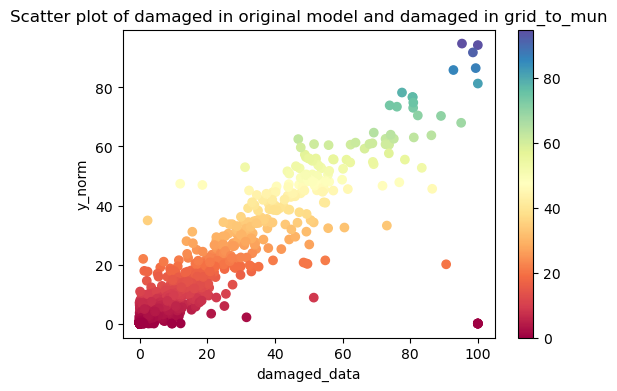

In [37]:
x = df_merged["DAM_perc_dmg"]
y = df_merged["y_norm"]
plt.rcParams.update({"figure.figsize": (6, 4), "figure.dpi": 100})
plt.scatter(x, y, c=y, cmap="Spectral")
plt.colorbar()
plt.title("Scatter plot of damaged in original model and damaged in grid_to_mun")
plt.xlabel("damaged_data")
plt.ylabel("y_norm")
plt.show()

Text(0, 0.5, 'Frequency')

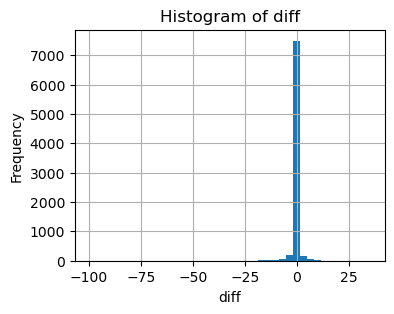

In [38]:
diff = df_merged["y_norm"] - df_merged["DAM_perc_dmg"]
diff.hist(bins=40, figsize=(4, 3))
plt.title("Histogram of diff")
plt.xlabel("diff")
plt.ylabel("Frequency")